#### Zakaria El Founoun

In [1]:
import numpy as np
from tqdm import tqdm

# 1 Générateur pseudo-aléatoire


In [2]:
# Définissons le générateur 


def uniform_generator(seed = 2023):
    np.random.seed(seed)
    return np.random.uniform(0, 1)

**Le générateur pseudo-aléatoire** utilisé pour la génération des numbre aléatoire est  de type **Mersenne Twister** 


**La graine** est fixé par la commande `np.random.seed(2023)` 

In [3]:
# Vérification que le nombre généré est le meme 

n_trails = 2

radom_number = uniform_generator()
for _ in range (100):
    if uniform_generator() != radom_number:
        print("L'algorithme ne fonctionne pas comme prévu")
        break

# 2 Méthode d’acceptation-rejet

In [5]:
# On va définir tout d'abord la fonction f(x)

def f(x):
    return np.exp(-0.5 * (x-1) ** 2) * abs(np.sin(np.pi * x))

* Comme on l'a vu dans le cours la fonction de densité cible notée g, peut etre connue à une constante multiplicative près, pour cela quitte à normaliser f par une constante de normalisation la rendant une fonction de densité, on va la confondre avec la fonction g.

* Il nous reste donc à trouver la fonction instrumental, l'existane de l'exponentiel et de la fonction quadratique, donne l'intuition de considérer ue densité gaussienne.
 
* On a alors $f(x) = exp(- \frac{(x - 1)^2}{2}) * |sin(\pi x)| \leq \sqrt{2 \pi } * q(x) $ où $q$  est la fonction de densité d'une gaussienne de moyene 1 et de variance 1 

In [79]:
def gaussian_density(mean, variance):
    return lambda x:(1/ np.sqrt(2 * np.pi * variance)) * np.exp((1/(2 * variance)) * (x - mean)**2)

q = gaussian_density(1,1)

def acceptation_rejet(proposal, n):
    res = np.empty(n)
    i = 0
    while i < n:
        u = np.random.uniform(0, 1)
        y = np.random.normal(1, 1)
        if u <= f(y) / (np.sqrt(2 * np.pi) * q(y)):
            res[i] = y
            i += 1
    return res

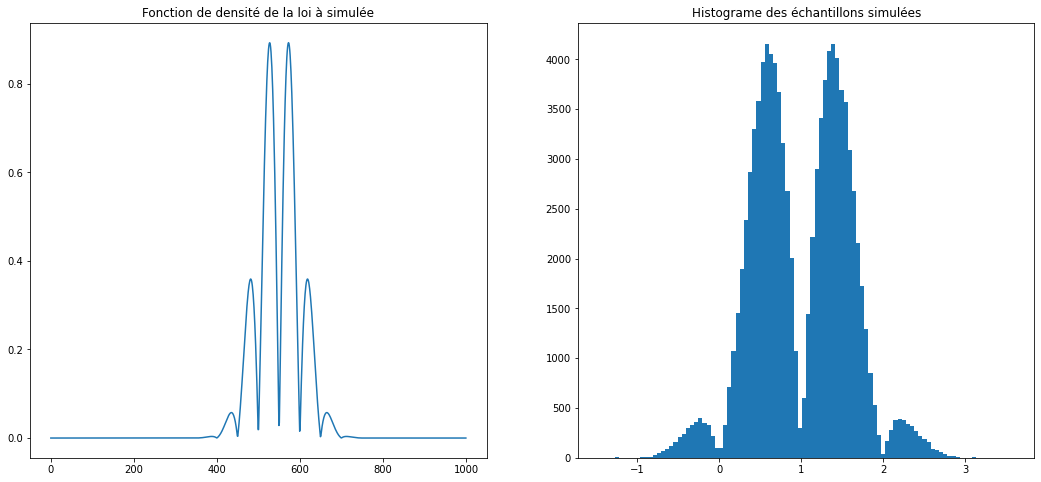

In [84]:
# let's plot the real distribution and the histogramm of the simulated samples

fig , axes = plt.subplots(1,2, figsize = (18,8))
axes[0].plot(f(np.linspace(-10,10,1000)))
axes[0].set_title("Fonction de densité de la loi à simulée")

simulations = acceptation_rejet(q, 100000)
axes[1].hist(simulations, bins = 100)
axes[1].set_title("Histograme des échantillons simulées")

fig.show()

# 3 Algorithme de Metropolis-Hasting

## 3.1 Simulation sur $\mathbb{R}$

In [7]:
from random import random
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import multivariate_normal 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [8]:

# Initialization
s = 1e-3
x0 = 0.0
nsamples = int(5e4)
df = 3
# Target / Prop
def logpdf(x):
    """
    Fonction qui renvoie la valeur de la log de la fonction de densité d'une loi chi2 
    """
    return chi2.logpdf(x, df)

def logproppdf(x, y):
    """
    Fonction qui renvoie la valeur de la log de la fonction de densité d'une loi normal 
    """
    return norm.logpdf(y, loc=x, scale=s)

def proprnd(x):
    """
    Fonction qui renvoie une valeur alétoire selon un loi gaussien
    """
    return norm.rvs(loc=x, scale=s)

def mhsim(x0, nsamples, logpdf, logproppdf, proprnd):
    x = np.zeros([nsamples])
    x[0] = x0
    x_i = x0
    accepts = 0
    total_trails = 0
    for i in range(1, nsamples):
        y_i = proprnd(x_i)
        a = min(1, np.exp(logpdf(y_i) - logpdf(x_i) + logproppdf(y_i, x_i) - logproppdf(x_i, y_i)))
        # a = np.exp(logpdf(y_i)) * np.exp(logproppdf(y_i, x_i)) / (np.exp(logpdf(x_i)) * np.exp(logproppdf(x_i, y_i)))
        accepts += a
        if a >= 1 :
            x[i] = y_i
            x_i = y_i
        else:
            u  = np.random.uniform()
            if u <= a :
                choice = y_i
            else:
                choice = x_i

            x[i] = choice
            x_i = choice
    accept_rate = accepts / nsamples

    return x, accept_rate
    
x, accept_rate = mhsim(x0, nsamples, logpdf, logproppdf, proprnd)

Text(0.5, 1.0, "Réalisaton oobtenu par l'lgorithme de M.H")

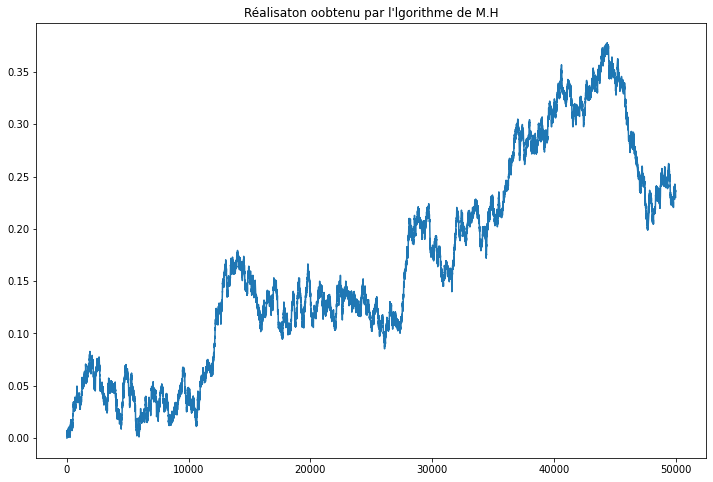

In [21]:
plt.figure(figsize=(12,8))
plt.plot(x)
plt.title("Réalisaton obtenu par l'lgorithme de M.H")

#### Convergence en fonction du paramètre s

* q(y | x) est donc la densité d'une loi gaussienne de moyenne x et d'écart type s 
* Dans l'implementation précédante, on remarque que puisque: q(y | x) = q(x |y) alors le terme en q va se simplifier
* D'après le cours , le rapport $\rho$ est construit de manière à vérifier le principe de réversibilité et que la seule condition qui reste est que:

$ \exists \epsilon, \alpha >  : |x - y| < \alpha \implies q(y|x) > \epsilon $ ce qui est vraie pour la densité gaussiénne considérée pour tout valeur de s, ainsi la convergence en norme VT vers la densité invarainte cible.

### Réglage automatique du taux d'acceptation:

* On peut utiliser l'algorithme Adaptive Metropolis (AM). L'idée de l'algorithme est de monitorer l'acceptance rate, et de le modifier de sorte à avoir la valeur désirée 

In [9]:
def logproppdf(x, y, s):
    """
    Fonction qui renvoie la valeur de la log de la fonction de densité d'une loi normal 
    """
    return norm.logpdf(y, loc=x, scale=s)

def proprnd(x, s):
    """
    Fonction qui renvoie une valeur alétoire selon un loi gaussien
    """
    return norm.rvs(loc=x, scale=s)

In [10]:
def adaptive_mh(x0, nsamples, logpdf, logproppdf, proprnd, acceptance_ratio_target = 0.5, s = 1, k = 100):
    x = np.zeros([nsamples])
    x[0] = x0
    x_i = x0
    accepts = 0
    s_history = []
    for i in range(1, nsamples):
        y_i = proprnd(x_i, s)
        a = min(1, np.exp(logpdf(y_i) - logpdf(x_i)))
        accepts += a
        if a >= 1 :
            x[i] = y_i
            x_i = y_i
        else:
            u  = np.random.uniform()
            if u <= a :
                choice = y_i
            else:
                choice = x_i
      
            x[i] = choice
            x_i = choice

        if i % 100 == 0:
            acceptance_rate = accepts / 100
            s_history.append(acceptance_rate)

            if acceptance_rate > acceptance_ratio_target:
                s *= 1.1

            elif acceptance_rate < acceptance_ratio_target:
                s /= 1.1

            accepts = 0

    return x, s_history

In [32]:
x, s_history = adaptive_mh(x0, nsamples, logpdf, logproppdf, proprnd, acceptance_ratio_target = 0.5, s = 1e-3, k = 100)

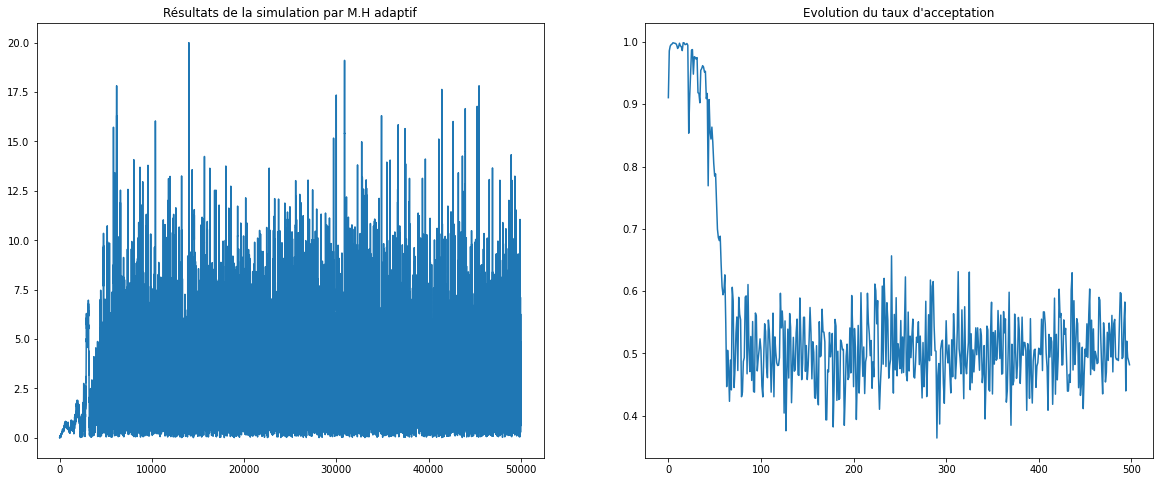

In [34]:
# Let's plot the results 
fig , axes = plt.subplots(1,2, figsize = (20,8))
axes[0].plot(x)
axes[0].set_title('Résultats de la simulation par M.H adaptif')
axes[1].plot(s_history)
axes[1].set_title("Evolution du taux d'acceptation")
fig.show()

### Détection automtique des problèmes de convergence 

* L'idée qu'on va utiliser c'est de générer plusieurs simulations partantes des états initiaux différentes et faire un test de kolmogorov 

100%|██████████| 10/10 [07:26<00:00, 44.68s/it]


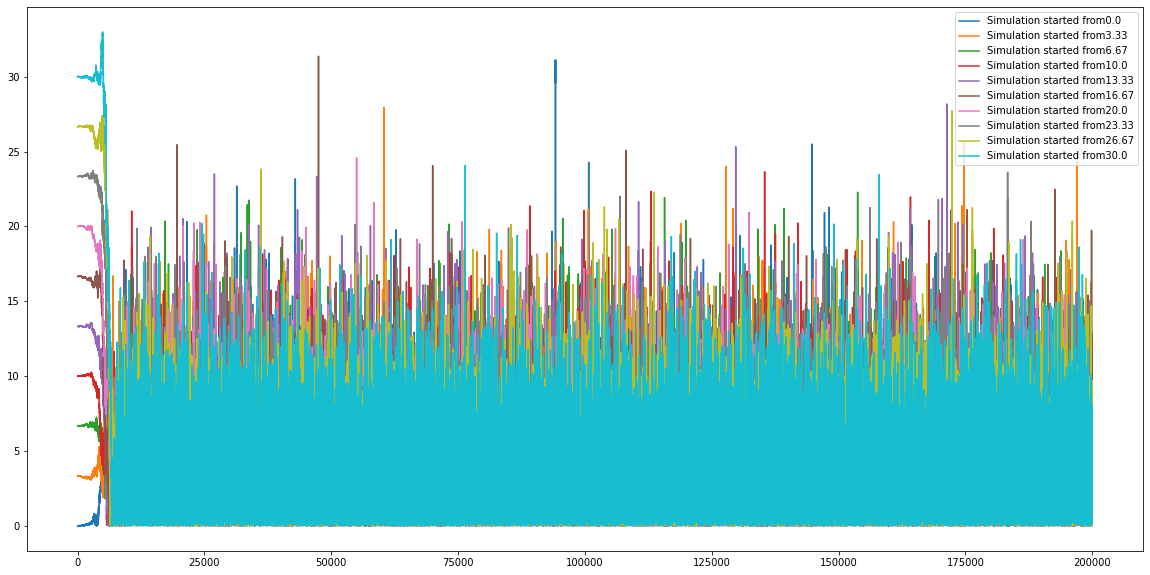

In [82]:
n_simulations = 10
nsamples = 200000
generated_chains = []

initial_points =  np.linspace(0, 30, n_simulations)
for x0 in tqdm(initial_points):
    generated_chains.append(adaptive_mh(x0, nsamples, logpdf, logproppdf, proprnd, acceptance_ratio_target = 0.5, s = 1e-3, k = 100))

chains = [chain[0] for chain in generated_chains]

# Let's visualize the generated simulations 

plt.figure(figsize= (20,10))
for i, chain in enumerate(chains):
    plt.plot(chain, label = f'Simulation started from{round(initial_points[i],2)}')
plt.legend()
plt.show()

### Remarque:
* On voit qu'il y'a une première phase de burn-in, on va donc couper les chaines et prendre les chaines à partir de l'échantillon 20000 (cette valeur dépend de l'état initial, s'il est grande le burn-in peut etre grand aussi)

In [178]:
# Kolmogorov-Smirnov pout tester la convergence 
from scipy.stats import kstest

def converge(chain, burnin_end= 190000):
    cdf = lambda x : chi2.cdf(x, 3)
    _, p_value = kstest(chain[burnin_end:], cdf)
    return p_value > 0.05


for i, chain in enumerate(chains):
    temp = True
    if not converge(chain):
        print(f"La simulation avec x0 = {initial_points[i]} n'a pas encore convergé")
        temp = False
if temp:
    print(" Toutes les simulations ont convergées")

La simulation avec x0 = 0.0 n'a pas encore convergé
La simulation avec x0 = 3.3333333333333335 n'a pas encore convergé
La simulation avec x0 = 10.0 n'a pas encore convergé
La simulation avec x0 = 13.333333333333334 n'a pas encore convergé
La simulation avec x0 = 16.666666666666668 n'a pas encore convergé
La simulation avec x0 = 23.333333333333336 n'a pas encore convergé
La simulation avec x0 = 26.666666666666668 n'a pas encore convergé
La simulation avec x0 = 30.0 n'a pas encore convergé


# 3.2 Un problème d’estimation


## 3.4 Travail

In [11]:
# construction du simulateur 
from scipy.integrate import ode

def func(t, y, params):
    q1, q2 = y
    x1, x2, x3 = params
    return [-(x1 + x3) * q1 + x2 * q2, x1 * q1  - x2 * q2]

def solution(params, t = np.arange(16)):
    y0 = [1,0]
    solver = ode(func)
    solver.set_integrator('dopri5')
    solver.set_initial_value(y0, t[0])
    solver.set_f_params(params)
    y = np.zeros((len(t), 2))
    y[0, :] = y0
    for i in range(1, len(t)):
        y[i, :] = solver.integrate(t[i])
        if not solver.successful():
            break
    return y[1:]

In [47]:
# Let's set a seed to make it reproductible 
generator = np.random.default_rng(2023)

def construct_q2(x):
    # génération du bruit
    q2 = solution(x)[:,1]
    return q2

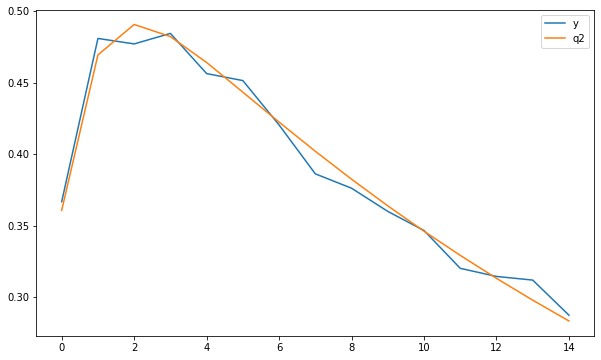

In [53]:
# let's visualize the different componenets of the problem 
s = 0.01
x = [0.6, 0.35, 0.15]
q2 = construct_q2(x)
epsilon = generator.normal(0, s, 15)
y_obs = q2 + epsilon

plt.figure(figsize= (10,6))
plt.plot(y, label = 'y')
plt.plot(q2, label = 'q2')
plt.legend()
plt.show()

In [56]:
# Loi à posteriori à une constante multiplicative près
def posteriori(theta_index, theta,s = 0.01):
    """
    Une fonction qui renvoie la loi a posteriori à une constante multiplicative près, en fixant 2 composante et en faisant varié que la composante theta_index
    """
    x = [0.6, 0.35, 0.15]
    x[theta_index] = theta
    q2 = construct_q2(x)
    res = np.exp( - sum((0.5/s**2) * (y_obs[i] - q2[i])**2 for i in range(15)))
    return res

# Visualisation de l'effet de la variance du bruit et de la posteriori

##### Visualisation de la loi a posteriori en fixant 2 composantes et en faisant varier la composante restante et aussi en variant s:

100%|██████████| 20/20 [00:00<00:00, 42.96it/s]


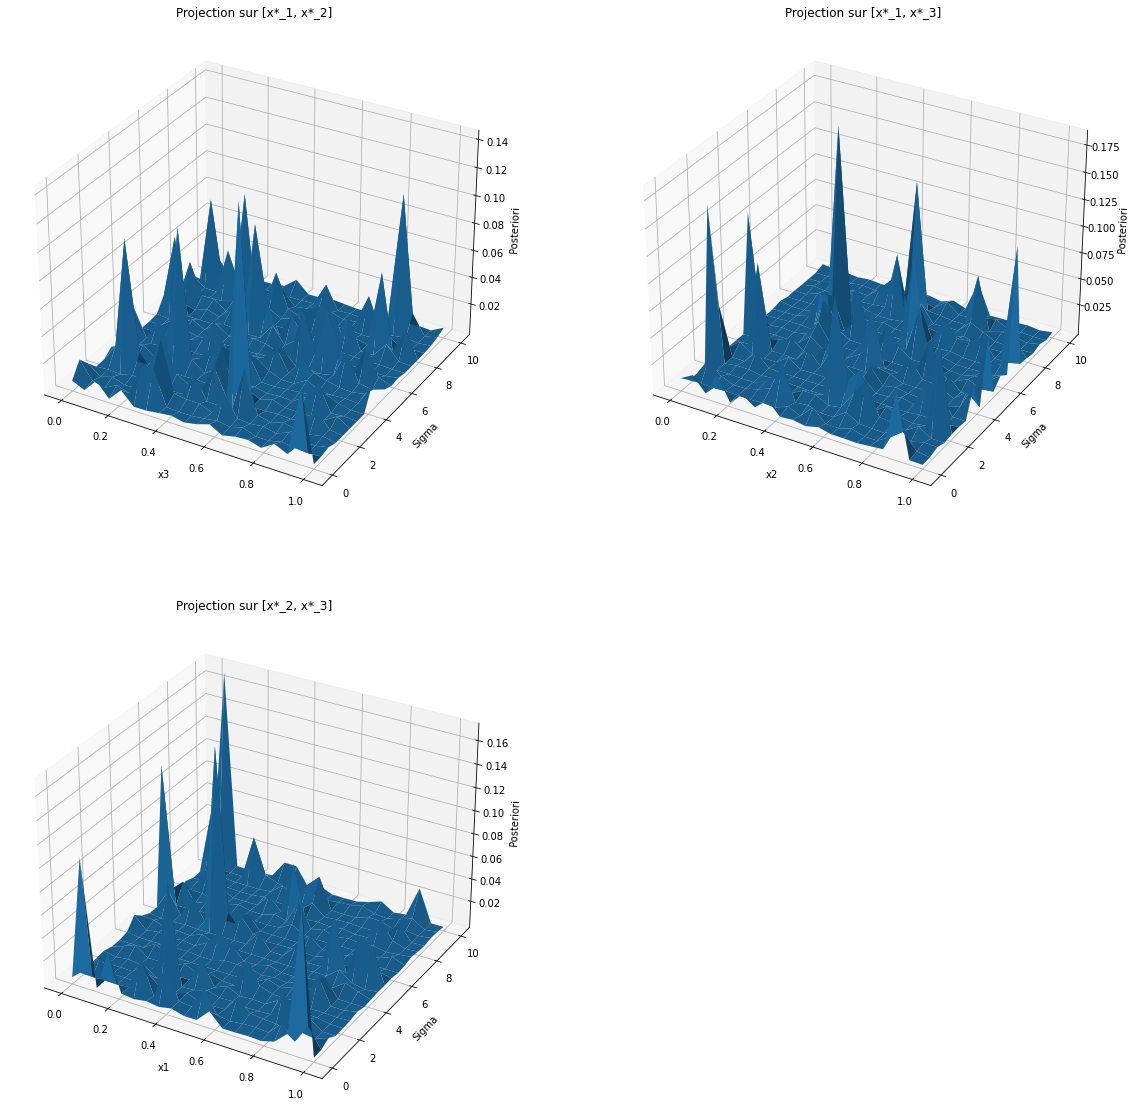

In [85]:
# avant de commencer on va redéfinir la fonction a posteriori pour reconstruire y
def posteriori_v2(theta_index, theta,s = 0.01):
    """
    Une fonction qui renvoie la loi a posteriori à une constante multiplicative près, en fixant 2 composante et en faisant varié que la composante theta_index
    """
    x = [0.6, 0.35, 0.15]
    x[theta_index] = theta
    q2 = construct_q2(x)
    epsilon = generator.normal(0, s, 15)
    y = q2 + epsilon
    res = np.exp( - sum((0.5/s**2) * (y[i] - q2[i])**2 for i in range(15)))
    return res

# Now let's make the plots 
thetas = np.linspace(0,1,20)
sigmas = np.linspace(0.001, 10, 20)


# projection sur la première et la 2ème composante de x*

X, Y = np.meshgrid(thetas, sigmas)

Z1 = np.zeros_like(X)

# Evaluate the function at each point in the grid
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Z1[i, j] = posteriori_v2(2, X[i, j], Y[i, j])

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X, Y, Z1)

# Add labels and show the plot
ax.set_xlabel('x3')
ax.set_ylabel('Sigma')
ax.set_zlabel('Posteriori')
ax.set_title('Projection sur [x*_1, x*_2]')

# projection sur la première et la 3ème composante de x*
Z2 = np.zeros_like(X)

# Evaluate the function at each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z2[i, j] = posteriori_v2(1, X[i, j], Y[i, j])

ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(X, Y, Z2)

# Add labels and show the plot
ax.set_xlabel('x2')
ax.set_ylabel('Sigma')
ax.set_zlabel('Posteriori')
ax.set_title('Projection sur [x*_1, x*_3]')


# projection sur la 2ème et la 3ème composante de x*
Z3 = np.zeros_like(X)

# Evaluate the function at each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z3[i, j] = posteriori_v2(0, X[i, j], Y[i, j])

ax = fig.add_subplot(223, projection='3d')
ax.plot_surface(X, Y, Z3)

# Add labels and show the plot
ax.set_xlabel('x1')
ax.set_ylabel('Sigma')
ax.set_zlabel('Posteriori')
ax.set_title('Projection sur [x*_2, x*_3]')

plt.show()

**Conclusion sur l'infuence de s :** la densité à postériori pour s faible est près d'une dirac autour de la vraie valeur, en aungmentant s on perd cette précision et plusieurs pics apparaissent , ce qui est naturelle, en fait plus s est faible plus l'influence du bruit est faible.

##  Utilisation de  l’algorithme de Metropolis-Hasting

In [59]:
def logproppdf(x, y, s):
    """
    Fonction qui renvoie la valeur de la log de la fonction de densité d'une loi normal multivariées
    """
    return multivariate_normal(mean= x, cov=s * np.eye(3)).logpdf(y)

def proprnd(x, s):
    """
    Fonction qui renvoie une valeur alétoire selon une loi gaussien multivariées
    """
    return multivariate_normal(mean= x, cov=s * np.eye(3)).rvs()

def logpdf(x):
    """
    Log de la loi a posteriori à une constante multiplicative près 
    """
    q2 = construct_q2(x)
    res = -sum((0.5/s**2) * (y_obs[i] - q2[i])**2 for i in range(15))
    return res 


def adaptive_mh(x0, nsamples, logpdf, logproppdf, proprnd, acceptance_ratio_target = 0.5, s = 1e-3, k = 100):
    x = []
    x.append(x0)
    x_i = x0
    accepts = 0
    acceptance_rate_history = []
    s_history = [s]
    for i in tqdm(range(1, nsamples)):
        y_i = np.clip(proprnd(x_i, s), 0, 1) # les valeurs devront etre entre 0 et 1
        a = min(1, np.exp(logpdf(y_i) - logpdf(x_i)))
        accepts += a
        if a >= 1 :
            x.append(y_i)
            x_i = y_i
        else:
            u  = np.random.uniform()
            if u <= a :
                choice = y_i
            else:
                choice = x_i
      
            x.append(choice)
            x_i = choice

        if i % 100 == 0:
            acceptance_rate = accepts / 100
            acceptance_rate_history.append(acceptance_rate)

            if acceptance_rate > acceptance_ratio_target:
                s *= 1.1

            elif acceptance_rate < acceptance_ratio_target:
                s /= 1.1
            s_history.append(s)
            accepts = 0

    return x, acceptance_rate_history, s_history

In [60]:
x0 = [0,0,0]
nsamples = 50000
x, acceptance_rate_history, s_history = adaptive_mh(x0, nsamples, logpdf, logproppdf, proprnd, acceptance_ratio_target = 0.5, s = 1e-3, k = 100)

100%|██████████| 49999/49999 [02:04<00:00, 402.31it/s]


### On choisira ensuite une valeur x dans la chaine générée qui maximize la loi à posteriori et regénérer le vecteur y 

In [61]:
chaine = np.array(x)

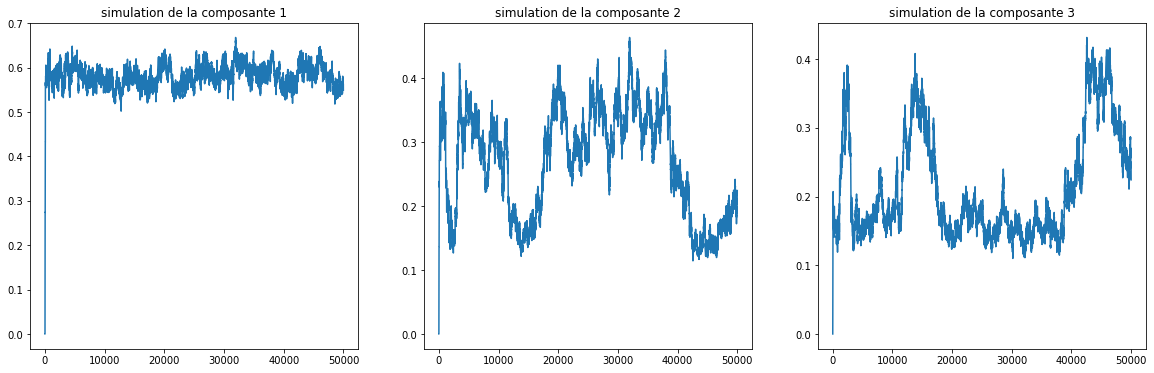

In [62]:
# on va en premier visualiser la simulation de chaque composante 

fig, axes  = plt.subplots(1,3 , figsize = (20,6))
for i in range(3):
    axes[i].plot(chaine[:, i])
    axes[i].set_title(f"simulation de la composante {i + 1}")
fig.show()

In [63]:
# on va chercher la composante qui maximize la densité à posteriori
probabilities = []
for x in tqdm(chaine):
    probabilities.append(np.exp(logpdf(x)))

100%|██████████| 50000/50000 [00:50<00:00, 993.05it/s] 


In [67]:
print(f"The estimated value using maximum a posterior is {chaine[np.argmax(probabilities)]}")

The estimated value using maximum a posterior is [0.57585083 0.31644885 0.16155029]


Pour estimer le maximum de la quantité de matière dans le compartiement (2), on peut  utiliser la valeur estimer de x et trouver q2 dans l'équation différentielle et notre estimateur sera ainsi max(q2).